In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
from matplotlib import pyplot as plt


In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# --------------------------
# 1. Transformations
# --------------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


cuda


In [3]:
# --------------------------
# 2. Load Oxford-IIIT Pet
# --------------------------
train_dataset = datasets.OxfordIIITPet(
    root="data",
    split="trainval",
    transform=transform_train,
    target_types="category",
    download=True
)

test_dataset = datasets.OxfordIIITPet(
    root="data",
    split="test",
    transform=transform_test,
    target_types="category",
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

num_classes = len(train_dataset.classes)

# --------------------------
# 3. Load pretrained model
# --------------------------
# model = models.resnet18(weights="IMAGENET1K_V1")   # Προεκπαιδευμένα βάρη
model = models.alexnet(weights="IMAGENET1K_V1")  # Εναλλακτικά

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final classifier
# model.fc = nn.Linear(model.fc.in_features, num_classes)
model.classifier[6] = nn.Linear(4096, num_classes)

model = model.to(device)


In [4]:
def train_one_epoch(model, loader, optimizer, criterion, device, epoch, epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    train_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(
            loss=loss.item(),
            acc=100 * correct / total
        )

    train_loss = running_loss / len(loader)
    train_acc = 100 * correct / total

    return train_loss, train_acc


def evaluate(model, loader, criterion, device, epoch=None, epochs=None):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    desc = "Validation" if epoch is None else f"Epoch {epoch+1}/{epochs} [Val]"
    val_bar = tqdm(loader, desc=desc, leave=False)

    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            val_bar.set_postfix(
                loss=loss.item(),
                acc=100 * correct / total
            )

    val_loss = running_loss / len(loader)
    val_acc = 100 * correct / total

    return val_loss, val_acc


In [5]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, epochs):
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device, epoch, epochs
        )

        val_loss, val_acc = evaluate(
            model, test_loader, criterion, device, epoch, epochs
        )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"TrainLoss: {train_loss:.4f} | ValLoss: {val_loss:.4f} | "
            f"TrainAcc: {train_acc:.2f}% | ValAcc: {val_acc:.2f}%"
        )

    return history


In [6]:
def plot_training_curves(results_dict):
    plt.figure(figsize=(12,5))

    # ---- Training Loss ----
    plt.subplot(2,2,1)
    for name, history in results_dict.items():
        plt.plot(history["train_loss"], label=f"{name} Train Loss")
    plt.title("Training Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2,2,2)
    for name, history in results_dict.items():
        plt.plot(history["train_acc"], label=f"{name} Train Accuracy")
    plt.title("Training Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    # ---- Validation Accuracy ----
    plt.subplot(2,2,3)
    for name, history in results_dict.items():
        plt.plot(history["val_loss"], label=f"{name} Val Loss")
    plt.title("Validation Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2,2,4)
    for name, history in results_dict.items():
        plt.plot(history["val_acc"], label=f"{name} Val Acc")
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [7]:
def show_predictions(model, loader, device, class_names, n=8):
    model.eval()

    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(16, 6))

    for i in range(n):
        plt.subplot(2, n//2, i+1)

        # unnormalize
        img = images[i].permute(1,2,0)
        img = img * torch.tensor([0.2675, 0.2565, 0.2761]) + torch.tensor([0.5071, 0.4867, 0.4408])
        img = torch.clamp(img, 0, 1)

        plt.imshow(img)
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]

        color = "green" if labels[i] == preds[i] else "red"

        plt.title(f"T: {true_label}\nP: {pred_label}", color=color, fontsize=10)
        plt.axis("off")

    plt.suptitle("Classification results (Green=Correct, Red=Wrong)", fontsize=14)
    plt.show()



Training with epochs=5


Epoch 1/5 | TrainLoss: 1.3114 | ValLoss: 0.9902 | TrainAcc: 61.82% | ValAcc: 69.86%


Epoch 2/5 | TrainLoss: 0.4483 | ValLoss: 0.9598 | TrainAcc: 85.19% | ValAcc: 71.52%


Epoch 3/5 | TrainLoss: 0.2842 | ValLoss: 0.9557 | TrainAcc: 90.65% | ValAcc: 72.47%


Epoch 4/5 | TrainLoss: 0.2048 | ValLoss: 0.9589 | TrainAcc: 92.96% | ValAcc: 72.72%


Epoch 5/5 | TrainLoss: 0.1689 | ValLoss: 0.9749 | TrainAcc: 94.35% | ValAcc: 72.69%

Training with epochs=10


Epoch 1/10 | TrainLoss: 1.2689 | ValLoss: 1.0293 | TrainAcc: 63.32% | ValAcc: 69.07%


Epoch 2/10 | TrainLoss: 0.4708 | ValLoss: 0.9542 | TrainAcc: 83.67% | ValAcc: 71.74%


Epoch 3/10 | TrainLoss: 0.2776 | ValLoss: 0.9574 | TrainAcc: 90.57% | ValAcc: 72.69%


Epoch 4/10 | TrainLoss: 0.1978 | ValLoss: 0.9855 | TrainAcc: 93.37% | ValAcc: 72.17%


Epoch 5/10 | TrainLoss: 0.1644 | ValLoss: 1.0147 | TrainAcc: 94.48% | ValAcc: 72.20%


Epoch 6/10 | TrainLoss: 0.1389 | ValLoss: 1.0307 | TrainAcc: 95.76% | ValAcc: 72.20%


Epoch 7/10 | TrainLoss: 0.1345 | ValLoss: 1.0411 | TrainAcc: 95.49% | ValAcc: 73.21%


Epoch 8/10 | TrainLoss: 0.1173 | ValLoss: 1.0692 | TrainAcc: 96.44% | ValAcc: 73.37%


Epoch 9/10 | TrainLoss: 0.1009 | ValLoss: 1.0874 | TrainAcc: 96.88% | ValAcc: 72.74%


Epoch 10/10 | TrainLoss: 0.0808 | ValLoss: 1.0830 | TrainAcc: 97.15% | ValAcc: 73.70%

Training with epochs=15


Epoch 1/15 | TrainLoss: 1.3115 | ValLoss: 0.9507 | TrainAcc: 61.39% | ValAcc: 70.81%


Epoch 2/15 | TrainLoss: 0.4473 | ValLoss: 0.9262 | TrainAcc: 84.59% | ValAcc: 71.68%


Epoch 3/15 | TrainLoss: 0.2718 | ValLoss: 0.9804 | TrainAcc: 90.82% | ValAcc: 71.35%


Epoch 4/15 | TrainLoss: 0.2030 | ValLoss: 1.0799 | TrainAcc: 93.23% | ValAcc: 71.11%


Epoch 5/15 | TrainLoss: 0.1725 | ValLoss: 1.0097 | TrainAcc: 94.18% | ValAcc: 73.04%


Epoch 6/15 | TrainLoss: 0.1316 | ValLoss: 1.0372 | TrainAcc: 95.57% | ValAcc: 73.29%


Epoch 7/15 | TrainLoss: 0.1172 | ValLoss: 1.0970 | TrainAcc: 95.65% | ValAcc: 71.49%


Epoch 8/15 | TrainLoss: 0.1136 | ValLoss: 1.0698 | TrainAcc: 96.09% | ValAcc: 72.88%


Epoch 9/15 | TrainLoss: 0.0953 | ValLoss: 1.1147 | TrainAcc: 97.15% | ValAcc: 73.02%


Epoch 10/15 | TrainLoss: 0.0758 | ValLoss: 1.1313 | TrainAcc: 97.64% | ValAcc: 72.61%


Epoch 11/15 | TrainLoss: 0.0769 | ValLoss: 1.2071 | TrainAcc: 97.36% | ValAcc: 71.74%


Epoch 12/15 | TrainLoss: 0.0656 | ValLoss: 1.1253 | TrainAcc: 97.93% | ValAcc: 73.62%


Epoch 13/15 | TrainLoss: 0.0697 | ValLoss: 1.1566 | TrainAcc: 97.58% | ValAcc: 73.26%


Epoch 14/15 | TrainLoss: 0.0655 | ValLoss: 1.1829 | TrainAcc: 97.85% | ValAcc: 72.94%


Epoch 15/15 | TrainLoss: 0.0720 | ValLoss: 1.2694 | TrainAcc: 97.66% | ValAcc: 72.20%


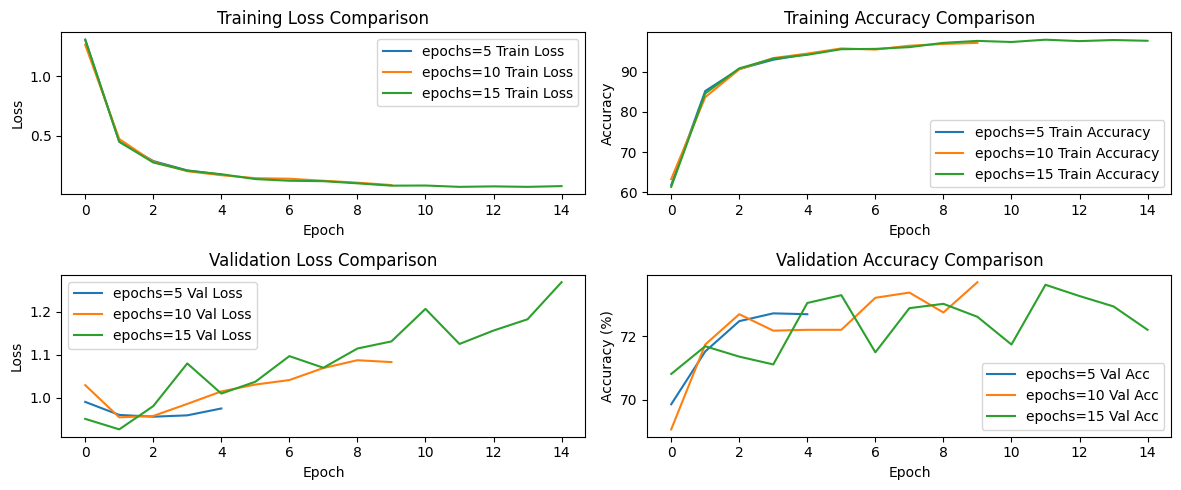

In [8]:

# --------------------------
# 6. Run training
# --------------------------

results = {}

for epochs in [5, 10, 15]:
    print(f"\nTraining with epochs={epochs}")

    model = models.alexnet(weights="IMAGENET1K_V1")
    for p in model.parameters():
        p.requires_grad = False

    model.classifier[6] = nn.Linear(4096, num_classes)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    history = train_model(model, train_loader, test_loader, optimizer, criterion, device, epochs)

    results[f"epochs={epochs}"] = history

plot_training_curves(results)


TRAINING WITH LR=0.01


Epoch 1/5 | TrainLoss: 5.5966 | ValLoss: 5.1509 | TrainAcc: 58.48% | ValAcc: 63.42%


Epoch 2/5 | TrainLoss: 2.8828 | ValLoss: 5.7478 | TrainAcc: 77.58% | ValAcc: 66.18%


Epoch 3/5 | TrainLoss: 1.9404 | ValLoss: 5.8550 | TrainAcc: 83.72% | ValAcc: 67.59%


Epoch 4/5 | TrainLoss: 1.8979 | ValLoss: 6.9805 | TrainAcc: 85.92% | ValAcc: 66.75%


Epoch 5/5 | TrainLoss: 1.6260 | ValLoss: 7.6173 | TrainAcc: 88.10% | ValAcc: 67.13%
TRAINING WITH LR=0.001


Epoch 1/5 | TrainLoss: 1.2933 | ValLoss: 0.9239 | TrainAcc: 62.31% | ValAcc: 71.08%


Epoch 2/5 | TrainLoss: 0.4175 | ValLoss: 0.9687 | TrainAcc: 86.03% | ValAcc: 71.00%


Epoch 3/5 | TrainLoss: 0.2762 | ValLoss: 0.9908 | TrainAcc: 90.73% | ValAcc: 72.04%


Epoch 4/5 | TrainLoss: 0.2087 | ValLoss: 0.9985 | TrainAcc: 92.88% | ValAcc: 72.64%


Epoch 5/5 | TrainLoss: 0.1647 | ValLoss: 1.0236 | TrainAcc: 94.35% | ValAcc: 72.17%
TRAINING WITH LR=0.0001


Epoch 1/5 | TrainLoss: 2.4259 | ValLoss: 1.5610 | TrainAcc: 36.20% | ValAcc: 63.31%


Epoch 2/5 | TrainLoss: 1.1541 | ValLoss: 1.1601 | TrainAcc: 71.71% | ValAcc: 69.91%


Epoch 3/5 | TrainLoss: 0.8464 | ValLoss: 1.0105 | TrainAcc: 78.40% | ValAcc: 71.74%


Epoch 4/5 | TrainLoss: 0.6811 | ValLoss: 0.9309 | TrainAcc: 82.66% | ValAcc: 73.15%


Epoch 5/5 | TrainLoss: 0.5809 | ValLoss: 0.8859 | TrainAcc: 84.97% | ValAcc: 73.70%


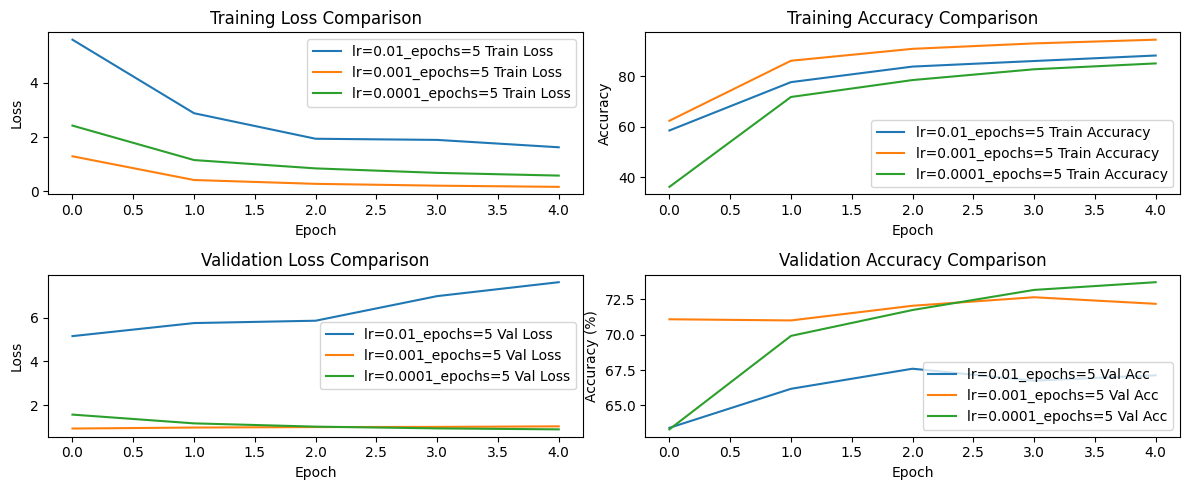

In [8]:
lrs = [1e-2, 1e-3, 1e-4]
results = {}
epochs=5
for lr in lrs:
    print(f"TRAINING WITH LR={lr}")
    model = models.alexnet(weights="IMAGENET1K_V1")
    model.classifier[6] = nn.Linear(4096, num_classes)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()


    history = train_model(model, train_loader, test_loader, optimizer, criterion, device, epochs)

    results[f"lr={lr}_epochs=5"] = history


plot_training_curves(results)

Training with LabelSmoothing0.1


Epoch 1/5 | TrainLoss: 1.9322 | ValLoss: 1.6242 | TrainAcc: 61.82% | ValAcc: 69.17%


Epoch 2/5 | TrainLoss: 1.2508 | ValLoss: 1.6405 | TrainAcc: 84.27% | ValAcc: 69.69%


Epoch 3/5 | TrainLoss: 1.1074 | ValLoss: 1.6502 | TrainAcc: 90.76% | ValAcc: 68.17%


Epoch 4/5 | TrainLoss: 1.0390 | ValLoss: 1.6440 | TrainAcc: 92.85% | ValAcc: 69.72%


Epoch 5/5 | TrainLoss: 0.9967 | ValLoss: 1.6441 | TrainAcc: 94.92% | ValAcc: 70.02%

--- Αποτελέσματα Loss Functions ---
Training with CrossEntropy


Epoch 1/5 | TrainLoss: 1.3071 | ValLoss: 0.9307 | TrainAcc: 62.53% | ValAcc: 71.30%


Epoch 2/5 | TrainLoss: 0.4544 | ValLoss: 0.9741 | TrainAcc: 85.30% | ValAcc: 71.38%


Epoch 3/5 | TrainLoss: 0.2546 | ValLoss: 0.9752 | TrainAcc: 91.36% | ValAcc: 72.01%


Epoch 4/5 | TrainLoss: 0.2061 | ValLoss: 1.0333 | TrainAcc: 92.83% | ValAcc: 71.49%


Epoch 5/5 | TrainLoss: 0.1780 | ValLoss: 0.9909 | TrainAcc: 94.18% | ValAcc: 72.80%

--- Αποτελέσματα Loss Functions ---


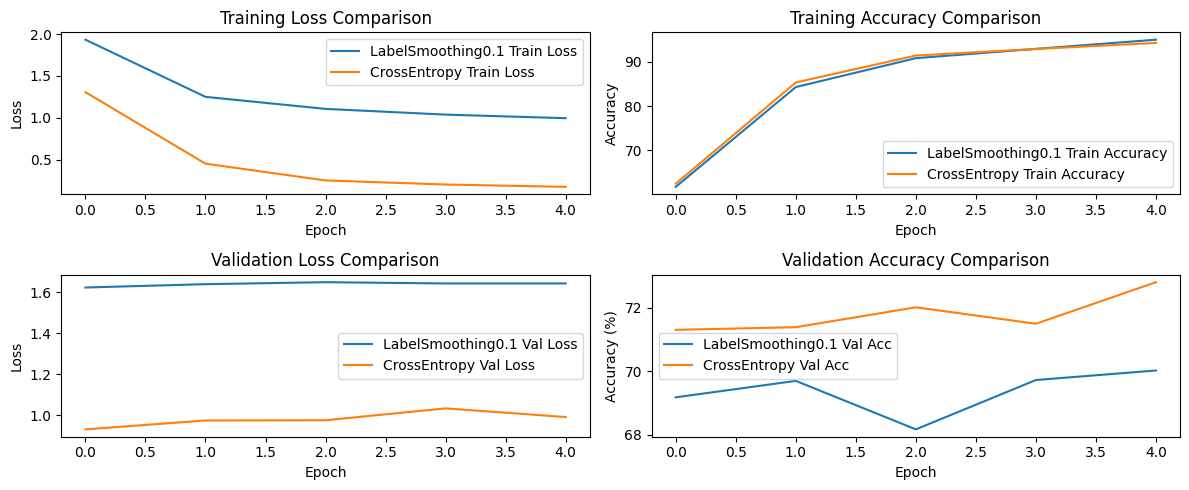

In [9]:
losses = {
    "LabelSmoothing0.1": nn.CrossEntropyLoss(label_smoothing=0.1),
    "CrossEntropy": nn.CrossEntropyLoss()
}
results = {}
for name, loss_fn in losses.items():
    print(f"Training with {name}")

    model = models.alexnet(weights="IMAGENET1K_V1")
    model.classifier[6] = nn.Linear(4096, num_classes)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=1e-3)

    history = train_model(model, train_loader, test_loader, optimizer, loss_fn, device, epochs=5)
    results[name] = history

    print("\n--- Αποτελέσματα Loss Functions ---")

plot_training_curves(results)


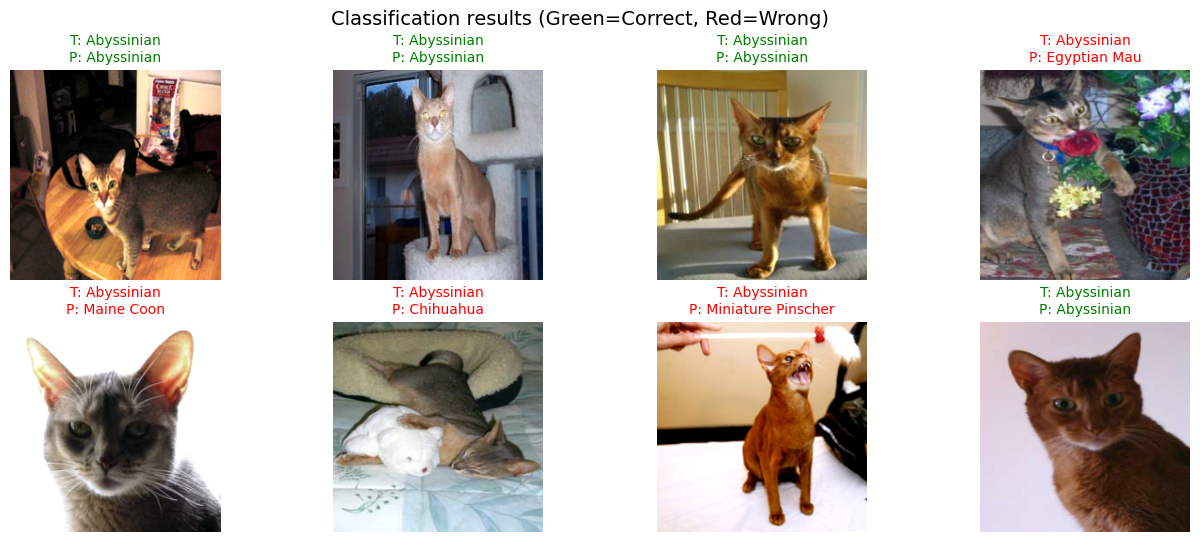

In [10]:
class_names = test_dataset.classes
show_predictions(model, test_loader, device, class_names, n=8)